## Lógica Computacional: 21/22## 
---
##Trabalho 3## 

$Grupo$ $7$ 

*   David José de Sousa Machado (A91665)
*   Ivo Miguel Gomes Lima (A90214)
---
#Inicialização

Para a resolução destes exercícios usamos a biblioteca [Python Z3Py](https://ericpony.github.io/z3py-tutorial/guide-examples.htm) que criou uma interface para o Z3. Esta biblioteca foi instalada com o comando `!pip install z3-solver`.

In [ ]:
!pip install z3-solver

     |████████████████████████████████| 32.9 MB 38.6 MB/s 


In [ ]:
from z3 import *
import networkx as nx
import matplotlib.pyplot as plt

###Contextualização do Problema

O objetivo deste trabalho é o uso de SMT’s para modelar e verificar propriedades lógicas de sistemas dinâmicos. O trabalho pode ser executado em Z3 , como o seu *wrapper* específico, ou desejavelmente com o *wrapper* PySMT , usando  Z3 e MatSAT e comparando os resultados.

No contexto do sistema de travagem `ABS` (*Anti-Lock Breaking System*), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.
    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $ V,v $ para descrever a **velocidade do corpo**  do veículo em relação ao solo e a **velocidade linear das rodas** também em relação ao solo. Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equações de Fluxo.

3. Os *switchs* (*jumps*) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não *derrape* muito.

<img style="-webkit-user-select: none;margin: auto;cursor: zoom-in;background-color: hsl(0, 0%, 90%);transition: background-color 300ms;" src="https://uc6ee6caa902b58ec80f5bc6af80.previews.dropboxusercontent.com/p/thumb/ABZMDSc_qZFoiz2ejRP8RDCzI-71B3hQhiFHLy3xGeY-m7Cr7aMzgm153bRFTlkw7s352riM8OR1zKUwh1S2k6TDH1-xpFY-zevVXnXGtjXfMZTdztNZmcFF1hmkLzSUPJe4R1oKahgUTB24uqvl02XNk1SAvA0tj-4PhaKVxSmVp6aJpw_7OYqTq0DnyMk-jb1F6FDgKht28aI1ARLjjRWq5BKlQD78_We7q0AHPOL9UomzVZlIsBY2wpGLl5XjeSMrGlyP1MIKILH_dykmeO0qoLucckgLvbyv6grZlkzpzHZLWiMKZ_uwghXJ9S_ICmHMKpfijL3laafT4PGo2kQmpzduHLrJuIkFUJS-hxqdfd4a3Dg45jk4R__TUj18MVPVQdLuigpODQK6EQ60qRDf/p.png" width="941" height="549">

###Equações de Fluxo

1.   Durante a travagem as forças são somente o **atrito** ($F = a$)
2.   Durante o movimento de um carro as forças que atuam são o **atrito** e a **força de compressão** ($F = a \cdot P$)
3.   No contacto corpo/rodas a **força de travagem** é dada pelo produto de **c**, que depende do modo, com diferença das velocidades, resultando na expressão $F = c\cdot(V - v)$
4.   Existe atrito entre corpo/ar, sendo designado de $b$
5.   A **dinâmica do sistema** é traduzida por $ -c \cdot (V - v)-b\ $ bem como $-a\cdot P\cdot (V - v)$ e no modo *Blocked* temos $(V = v)\ \land\ -c \cdot (V - v)-b = -a \cdot P - b$
6.   Os modos `Free` e `Blocked` só podem estar ativos 𝝅 segundos. Quem garante isso é o $jump(V, v, t, V', v', t')$ com origem nesses modos.
7.   No início do problema $V$ e $v$ assumem o valor dado como *input* inicialmente, ou seja têm o valor de $v_0$

###Exemplo do sistema de travagem `ABS`

Considere o seguinte autómato híbrido que modela o comportamento de um sistema de travagem.

<a href="https://app.gleek.io/diagrams/Q0B689ESceAdwvuVcuUwtQ" target="_blank">
    <img src="https://sketchertest.blob.core.windows.net/previewimages/Q0B689ESceAdwvuVcuUwtQ.png" alt="ABS lógica" title="ABS lógica" />
</a>

###Verificação de autómatos híbridos

Podemos verificar propriedades de segurança de autómatos híbridos codificando a semântica dos mesmos e usando depois os procedimentos de verificação fornecidos pelas *Bounded Model Checking* (BMC).

Na codificação em Z3 é conveniente usar um tipo enumerado para implementar os modos. No caso do sistema de travagem  `ABS` podemos declarar esse tipo da seguinte forma:

In [ ]:
Mode, (Start, Free, Stopping, Blocked, Stopped) = EnumSort('Mode', ('Start','Free','Stopping','Blocked','Stopped'))

###Lógica Temporal Linear (LTL)

O veículo imobiliza-se completamente em menos de $t$ segundos.

$$t \geq t' \rightarrow mode = Stopped \lor (vv \leq 0 \land vr \leq 0)$$

A velocidade $V$ diminui sempre ao longo do tempo:

$$t < t' \rightarrow V > V' $$

## Inicialização
A ideia básica é incluir nos estados do `ABS` para além das variáveis contínuas do autómato híbrido duas variáveis especiais:
*   uma variável contínua que denota o tempo ( t )
*   uma variável discreta que denota o modo de funcionamento ( m )

Num estado inicial teremos:
$$ t = 0 \wedge m = Start \wedge  v_{veículo} = v_{rodas} = v_0$$

## Transições

As transições do `ABS` incluem os dois tipos de transição que podem ocorrer num autómato híbrido:


1.   Transições *timed* associadas ao modo `Free` , `Blocked`, `Stopping` e `Stopped`
2.   Transições *untimed* descrevem os switches entre modos


As transições untimed podem ser obtidas através de uma codificação muito directa das guardas e efeitos especificadas nos switches, com a restrição que o tempo não evolui nestas transições, nem as variáveis contínuas se modificam a não ser que lhes seja explicitamente atribuído um novo valor no efeito do switch. 

Portanto no caso do no caso do sistema de travagem temos 6 transições deste tipo:

1.   A transição de $Start\rightarrow Free$ expressa-se da seguinte forma:

$$ m = Start \wedge m' = Free \wedge vv' = vv \wedge vr' = vr \wedge t' = t \wedge timer' = 0 $$

2.   A transição de $Free\rightarrow Stopped$ expressa-se da seguinte forma:

$$ m = Free \wedge m' = Stopped \wedge vv = vv' \wedge vr = vr' \wedge t' = t \wedge timer' = 0 \wedge vr = 0 \wedge vv = 0$$

3.   A transição de $Free\rightarrow Stopping$ expressa-se da seguinte forma:

$$ m = Free \wedge m' = Stopping \wedge vv = vv' \wedge vr = vr' \wedge t' = t \wedge timer' = 0$$

4.   A transição de $Stopping\rightarrow Blocked$ expressa-se da seguinte forma:

$$ m = Stopping \wedge m' = Blocked \wedge vv = vr \wedge vv = vv' \wedge vr = vr' \wedge t' = t \wedge timer' = 0$$

5.   A transição de $Stopping\rightarrow Stopped$ expressa-se da seguinte forma:

$$ m = Stopping \wedge m' = Stopped \wedge vv = vv' \wedge vr = vr' \wedge t' = t \wedge timer' = 0 \wedge vr = 0 \wedge vv = 0 $$

6.   A transição de $Blocked\rightarrow Free$ expressa-se da seguinte forma:

$$ m = Blocked \wedge m' = Free \wedge vv = vv' \wedge vr = vr' \wedge t' = t \wedge timer' = 0 \wedge timer = tau$$

7.   A transição de $Blocked\rightarrow Stopped$ expressa-se da seguinte forma:

$$ m = Blocked \wedge m' = Stopped \wedge vv = vv' \wedge vr = vr' \wedge t' = t \wedge timer' = 0 \wedge vr = 0 \wedge vv = 0$$

Com esta técnica, no caso do sistema de travagem teríamos as seguintes quatro transições *timed*:

$$
m = Free \wedge m' = m \wedge vr > vr' \wedge vv > vv' \wedge vv >= 0 \wedge vr >= 0 \wedge vv' >= 0 \wedge vr' >= 0 \wedge vv >= vr \wedge vv <= v0 \wedge (vv - vr) <= dif \wedge t' > t \wedge timer' = timer + (t' - t) \wedge (vr' - vr) <= (cF * dif - a*P) * (t' - t) \wedge -(vv' - vv) <= (cF * dif + b) * (t' - t) \\
\vee\\
m = Blocked \wedge m' = m \wedge vr > vr' \wedge vv > vv' \wedge vv >= 0 \wedge vr >= 0 \wedge vv' >= 0 \wedge vr' >= 0 \wedge vv >= vr \wedge vv <= v0 \wedge (vv - vr) <= dif \wedge t' > t \wedge timer' = timer + (t' - t) \wedge \\ (vr' - vr) = (-a*P - b) * (t' - t), (vv' - vv) = (-a*P - b) * (t' - t)\\
\vee\\
m = Stopping \wedge m' = m \wedge vr > vr' \wedge vv > vv' \wedge vv >= 0 \wedge vr >= 0 \wedge vv' >= 0 \wedge vr' >= 0 \wedge vv >= vr \wedge vv <= v0 \wedge (vv - vr) <= dif \wedge t' > t \wedge timer = 0 \wedge timer' = timer \wedge (vr' - vr) <= (cS * dif - a*P) * (t' - t) \wedge -(vv' - vv) <= (cS * dif + b) * (t' - t) \\ 
\vee\\
m = Stoppeded \wedge m' = m \wedge vr > vr' \wedge vv > vv' \wedge vv >= 0 \wedge vr >= 0 \wedge vv' >= 0 \wedge vr' >= 0 \wedge vv >= vr \wedge vv <= v0 \wedge (vv - vr) <= dif \wedge t' > t \wedge timer = 0, timer' = timer \wedge vr = 0 \wedge vv = 0 \\
$$



> Nota: $a = 0.01$, $b = 0.4$,  $cF = 0.2$,  $cS = 2$, $dif = 5$, $eps = 0.1$ e $P = 1000$.

##Simulações

In [ ]:
def plot_speeds(T, VV, VR):
    # 16:9
    fig = plt.figure(figsize=(10.6, 6))
    plt.plot(T, VV, label="Veículo")
    plt.plot(T, VR, label="Rodas")
    plt.ylabel('Velocidade (m/s)')
    plt.xlabel('Tempo (s)')
    plt.grid(True)

def frac2float(num):
    return float(num.numerator_as_long())/float(num.denominator_as_long())

###Declaração de variáveis

In [ ]:
# Dados para um Golf Mk6
consts = {
    "a": 0.01,
    "b": 0.4,
    "cFree": 0.5,
    "cStopping": 8,
    "P": 1000,
    "v0": 27
}

constsT3 = {
    "a": 0.01,
    "b": 0.4,
    "cFree": 0.3,
    "cStopping": 3,
    "P": 1000,
    "v0": 20
}

dicio = {
    "Start": {
        "trans": ["Free"]
    },
    "Free": {
        "trans": ["Stopping", "Stopped"]
    },
    "Stopping": {
        "trans": ["Blocked", "Stopped"]
    },
    "Blocked": {
        "trans": ["Free", "Stopped"]
    },
    "Stopped": []
}

[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


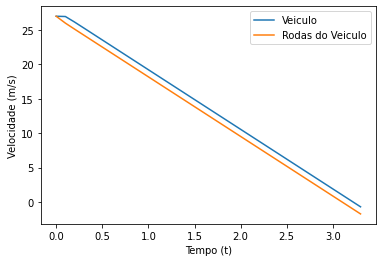

In [ ]:
# Função para calcular o epsilon dadas certas constantes
def find_epsilon(a, b, cF, cS, P, v0, time, epsilon):
    Precision = 1
    v = v0
    r = v0
    t = 0
    dt = 0.1

    V = [v]
    R = [r]
    T = [t]

    while t < time and (v >= 0 or r >= 0):
        dif = round((v-r), Precision)

        c = cF if dif <= epsilon else cS

        t += dt
        v += (-c * (v-r) -b) * dt
        r += ( c * (v-r) -a * P) * dt

        V.append(v)
        R.append(r)
        T.append(t)
    
    Dif = [round(V[i] - R[i], Precision) for i in range(len(V))]
    print(Dif)
    plt.plot(T, V, T, R)
    plt.legend(['Veiculo', 'Rodas do Veiculo'], loc=1)
    plt.ylabel('Velocidade (m/s)')
    plt.xlabel('Tempo (t)')

    return max(set(Dif), key=Dif.count)

epsilon = find_epsilon(*consts.values(), 20, 0)

[0, 1.0, 1.8, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1, 1.0, 1.9, 1.1]


1.0

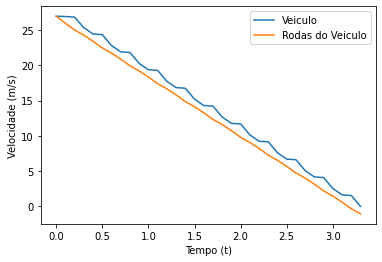

In [ ]:
find_epsilon(*consts.values(), 20, epsilon)
epsilon

## Implementação em Z3
Podemos agora declarar as variáveis correspondente ao sistema de travagem da seguinte forma:

In [ ]:
def declare(i):
    s = {}
    s['t'] = Real('t'+str(i))         # tempo
    s['m'] = Const('m'+str(i),Mode)   # mode
    s['vv'] = Real('vv'+str(i))       # velocidade do veiculo
    s['vr'] = Real('vr'+str(i))       # velocidade das rodas
    s['timer'] = Real('timer'+str(i)) # contador de tempo

    return s

Codificação dos predicados Z3 `init` e `trans` que caracterizam, respectivamente, os estados iniciais e as transições.

In [ ]:
def init(s, v0):
    return And(s['t'] == 0, s['timer'] == 0, s['m'] == Start, s['vv'] == v0, s['vr'] == v0)

In [ ]:
def trans(s, p, a, b, cF, cS, P, v0):
    tau = 0.3
    dif = 5
    eps = 0.1
    
    # Untimed
    untimed = And(s['vv'] == p['vv'], s['vr'] == p['vr'], s['t'] == p['t'], p['timer'] == 0)
    stopped = And(s['vr'] == 0, s['vv'] == 0)

    start2free       = And(s['m'] == Start,    p['m'] == Free,     untimed) 
    free2stopped     = And(s['m'] == Free,     p['m'] == Stopped,  untimed, stopped)
    free2stopping    = And(s['m'] == Free,     p['m'] == Stopping, untimed, s['timer'] == tau)
    stopping2stopped = And(s['m'] == Stopping, p['m'] == Stopped,  untimed, stopped)
    stopping2blocked = And(s['m'] == Stopping, p['m'] == Blocked,  untimed, s['vv'] == s["vr"])
    blocked2stopped  = And(s['m'] == Blocked,  p['m'] == Stopped,  untimed, stopped)
    blocked2free     = And(s['m'] == Blocked,  p['m'] == Free,     untimed, s['timer'] == tau)
    
    # Timed
    timed = And(s['m'] == p['m'], p['t'] > s['t'])
    
    # spd always decreases, spd always >= 0, V_corpo always >= V_rodas, V_corpo always <= V_inicial
    spdLimits = And(
            s['vr'] > p['vr'], s['vv'] > p['vv'],
            s['vv'] >= 0, s['vr'] >= 0, p['vv'] >= 0, p['vr'] >= 0,
            s['vv'] >= s['vr'], s['vv'] <= v0, (s['vv'] - s['vr']) <= dif
        )

    # advance timer and freeze timer
    tickTimer = And(p['timer'] == s['timer'] + (p['t'] - s['t']))
    freezeTimer = And(s['timer'] == 0, p['timer'] == s['timer'])

    # spd hits 0 and remains 0
    stops = And(s['vr'] == 0, s['vr'] == p['vr'], s['vv'] == 0, s['vv'] == p['vv'])

    # Diferencial for free
    vrFree = And((p['vr'] - s['vr']) <= (cF * dif - a*P) * (p['t'] - s['t']))
    vvFree = And(-(p['vv'] - s['vv']) <= (cF * dif + b) * (p['t'] - s['t']))
    boundsFree = And(vrFree, vvFree)

    # Diferencial for stopping
    vrStop = And((p['vr'] - s['vr']) <= (cS * dif - a*P) * (p['t'] - s['t']))
    vvStop = And(-(p['vv'] - s['vv']) <= (cS * dif + b) * (p['t'] - s['t']))
    boundsStop = And(vrStop, vvStop)

    # Diferencial for blocked
    boundsBlock = And((p['vr'] - s['vr']) == (-a*P - b) * (p['t'] - s['t']), (p['vv'] - s['vv']) == (-a*P - b) * (p['t'] - s['t']))

    free2free         = And(s['m'] == Free,     spdLimits, timed, tickTimer, boundsFree)
    blocked2blocked   = And(s['m'] == Blocked,  spdLimits, timed, tickTimer, boundsBlock)
    stopping2stopping = And(s['m'] == Stopping, spdLimits, timed, freezeTimer, boundsStop)
    stopped2stopped   = And(s['m'] == Stopped,  spdLimits, timed, freezeTimer, stops)

    return Or(start2free, free2stopping, stopping2blocked, stopping2stopped, blocked2free, blocked2stopped, free2free, blocked2blocked, stopping2stopping, stopped2stopped)

Outra codificação possível para as transições.

1.   A transição de $Free\rightarrow Stopped$ expressa-se da seguinte forma:

$$ m = Free \wedge m' = Stopped \wedge vr <= eps \wedge vv <= eps \wedge vr' = 0 \wedge vv' = 0$$

2.   A transição de $Stopping\rightarrow Stopped$ expressa-se da seguinte forma:

$$ m = Stopping \wedge m' = Stopped \wedge vr <= eps \wedge vv <= eps \wedge vr' = 0 \wedge vv' = 0 $$

3.   A transição de $Blocked\rightarrow Stopped$ expressa-se da seguinte forma:

$$ m = Blocked \wedge m' = Stopped \wedge vr <= eps \wedge vv <= eps \wedge vr' = 0 \wedge vv' = 0$$

Com esta técnica, no caso do sistema de travagem teríamos as seguintes quatro transições *timed*:

$$
m = Free \wedge m' = m \wedge vr > vr' \wedge vv > vv' \wedge vv >= 0 \wedge vr >= 0 \wedge vv' >= 0 \wedge vr' >= 0 \wedge vv >= vr \wedge vv <= v0 \wedge (vv - vr) <= dif \wedge t' > t \wedge timer' = timer + (t' - t) \wedge (vr' - vr) <= (cF * dif - a*P) * (t' - t) \wedge -(vv' - vv) <= (cF * dif + b) * (t' - t) \wedge timer < tau \\
\vee\\
m = Blocked \wedge m' = m \wedge vr > vr' \wedge vv > vv' \wedge vv >= 0 \wedge vr >= 0 \wedge vv' >= 0 \wedge vr' >= 0 \wedge vv >= vr \wedge vv <= v0 \wedge (vv - vr) <= dif \wedge t' > t \wedge timer' = timer + (t' - t) \wedge \\ (vr' - vr) = (-a*P - b) * (t' - t), (vv' - vv) = (-a*P - b) * (t' - t) \wedge timer < tau
$$

In [ ]:
def trans2(s, p, a, b, cF, cS, P, v0):
    tau = 0.3
    dif = 5
    eps = 0.1
    
    # Untimed
    untimed = And(s['vv'] == p['vv'], s['vr'] == p['vr'], s['t'] == p['t'], p['timer'] == 0)
    stopped = And(s['vr'] <= eps, s['vv'] <= eps, p['vr'] == 0, p['vv'] == 0)

    start2free       = And(s['m'] == Start,    p['m'] == Free,     untimed) 
    free2stopped     = And(s['m'] == Free,     p['m'] == Stopped,  stopped)
    free2stopping    = And(s['m'] == Free,     p['m'] == Stopping, untimed, s['timer'] == tau)
    stopping2stopped = And(s['m'] == Stopping, p['m'] == Stopped,  stopped)
    stopping2blocked = And(s['m'] == Stopping, p['m'] == Blocked,  untimed, s['vv'] == s["vr"])
    blocked2stopped  = And(s['m'] == Blocked,  p['m'] == Stopped,  stopped)
    blocked2free     = And(s['m'] == Blocked,  p['m'] == Free,     untimed, s['timer'] == tau)
    
    # Timed
    timed = And(s['m'] == p['m'], p['t'] > s['t'])
    
    # spd always decreases, spd always >= 0, V_corpo always >= V_rodas, V_corpo always <= V_inicial
    spdLimits = And(
            s['vr'] >= p['vr'], s['vv'] >= p['vv'],
            s['vv'] >= 0, s['vr'] >= 0, p['vv'] >= 0, p['vr'] >= 0,
            s['vv'] >= s['vr'], s['vv'] <= v0, (s['vv'] - s['vr']) <= dif
        )

    # advance timer and freeze timer
    tickTimer = And(p['timer'] == s['timer'] + (p['t'] - s['t']))
    freezeTimer = And(s['timer'] == 0, p['timer'] == s['timer'])

    # spd hits 0 and remains 0
    stops = And(s['vr'] == 0, s['vr'] == p['vr'], s['vv'] == 0, s['vv'] == p['vv'])

    # Diferencial for free
    vrFree = And((p['vr'] - s['vr']) <= (cF * dif - a*P) * (p['t'] - s['t']))
    vvFree = And(-(p['vv'] - s['vv']) <= (cF * dif + b) * (p['t'] - s['t']))
    boundsFree = And(vrFree, vvFree)

    # Diferencial for stopping
    vrStop = And((p['vr'] - s['vr']) <= (cS * dif - a*P) * (p['t'] - s['t']))
    vvStop = And(-(p['vv'] - s['vv']) <= (cS * dif + b) * (p['t'] - s['t']))
    boundsStop = And(vrStop, vvStop)

    # Diferencial for blocked
    boundsBlock = And(p['vv'] <= p['vr'] + eps, p['vv'] >= p["vr"] - eps, (p['vv'] - s['vv']) == (-a*P - b) * (p['t'] - s['t']))

    free2free         = And(s['m'] == Free,     spdLimits, timed, tickTimer, boundsFree, s['timer'] < tau)
    blocked2blocked   = And(s['m'] == Blocked,  spdLimits, timed, tickTimer, boundsBlock, s['timer'] < tau)
    stopping2stopping = And(s['m'] == Stopping, spdLimits, timed, freezeTimer, boundsStop)
    stopped2stopped   = And(s['m'] == Stopped,  spdLimits, timed, freezeTimer, stops)

    return Or(start2free, free2stopping, stopping2blocked, stopping2stopped, blocked2free, blocked2stopped, free2free, blocked2blocked, stopping2stopping, stopped2stopped)

Outra codificação possível para as transições *timed*.

In [ ]:
def init(s, v0):
    return And(s['t'] == 0, s['timer'] == 0, s['m'] == Start, s['vv'] == v0, s['vr'] == v0)

def trans(s, p, a, b, cF, cS, P, v0):
    tau = 0.3
    eps = 0.5
    
    # Untimed
    untimed = And(s['vv'] == p['vv'], s['vr'] == p['vr'], s['t'] == p['t'], p['timer'] == 0)
    stopped = And(s['vr'] == 0, s['vv'] == 0)

    start2free       = And(s['m'] == Start,    p['m'] == Free,     untimed)
    free2stopping    = And(s['m'] == Free,     p['m'] == Stopping, untimed, s['timer'] == tau)
    free2stopped     = And(s['m'] == Free,     p['m'] == Stopped,  untimed, stopped)
    stopping2stopped = And(s['m'] == Stopping, p['m'] == Stopped,  untimed, stopped)
    stopping2blocked = And(s['m'] == Stopping, p['m'] == Blocked,  untimed, (s['vv'] - s["vr"]) <= eps, s['vv'] > 0)
    blocked2stopped  = And(s['m'] == Blocked,  p['m'] == Stopped,  untimed, stopped)
    blocked2free     = And(s['m'] == Blocked,  p['m'] == Free,     untimed, s['timer'] == tau)
    
    # Timed
    timed = And(s['m'] == p['m'], p['t'] > s['t'])
    
    # spd always decreases, spd always >= 0, V_corpo always >= V_rodas, V_corpo always <= V_inicial
    spdLimits = And(s['vr'] >= p['vr'], s['vv'] >= p['vv'],
                    s['vv'] >= 0, s['vr'] >= 0, p['vv'] >= 0, p['vr'] >= 0,
                    s['vv'] >= s['vr'], p['vv'] >= p['vr'], s['vv'] <= v0)

    # advance timer and freeze timer
    tickTimer = And(p['timer'] == s['timer'] + (p['t'] - s['t']))
    freezeTimer = And(s['timer'] == 0, p['timer'] == s['timer'])

    # spd hits 0 and remains 0
    stops = And(s['vr'] == 0, s['vr'] == p['vr'], s['vv'] == 0, s['vv'] == p['vv'])

    # Diferencial for Free/Stop
    deltaV = lambda c, dif: And(
            s['vv'] - s['vr'] >= dif, s['vv'] - s['vr'] < dif + 1,
            (p['vv'] - s['vv']) == (-c * dif - b) * (p['t'] - s['t']),
            (p['vr'] - s['vr']) == (c * dif - a*P) * (p['t'] - s['t'])
        )
    
    boundsFree = Or([deltaV(cF, dif) for dif in range(v0)])
    boundsStop = Or([deltaV(cS, dif) for dif in range(v0)])

    # Diferencial for blocked
    boundsBlock = And(p['vv'] <= p["vr"] + eps, p['vv'] >= p["vr"] - eps, (p['vv'] - s['vv']) == (-a*P - b) * (p['t'] - s['t']))

    free2free         = And(s['m'] == Free,     timed, spdLimits, tickTimer, boundsFree, s['timer'] <= tau)
    blocked2blocked   = And(s['m'] == Blocked,  timed, spdLimits, tickTimer, boundsBlock, s['timer'] <= tau)
    stopping2stopping = And(s['m'] == Stopping, timed, spdLimits, freezeTimer, boundsStop, s['vv'] > 0, (s['vv'] - s["vr"]) > eps)
    stopped2stopped   = And(s['m'] == Stopped,  timed, spdLimits, freezeTimer, stops)

    return Or(start2free, free2stopping, free2stopped, stopping2stopped, stopping2blocked, blocked2free, blocked2stopped, free2free, blocked2blocked, stopping2stopping, stopped2stopped)

Adaptação da função `gera_traco` implementada nas aulas por forma a imprimir todas as variáveis contínuas como números de virgula flutuante.

In [ ]:
def gera_traco(declare, init, trans, k, consts):
    s = Solver()
    traco = [declare(i) for i in range(k)]
    s.add(init(traco[0], consts["v0"]))

    for i in range(k-1):
        s.add(trans(traco[i], traco[i+1], *consts.values()))
    
    #s.add(traco[k-1]['m'] == Stopped)

    if s.check() == sat:
        m = s.model()
        for i in range(k):
            print("Estado:", i)
            for v in traco[i]:
                res = m[traco[i][v]]
                if res.sort() != RealSort():
                    print(v, '=', res)
                else:
                    print(v, '=', frac2float(res))
            print()
        
        T  = [frac2float(m[traco[i]["t"]]) for i in range(k)]
        VV = [frac2float(m[traco[i]["vv"]]) for i in range(k)]
        VR = [frac2float(m[traco[i]["vr"]]) for i in range(k)]
        return T, VV, VR
    else:
        print("Não tem solução.")

Estado: 0
t = 0.0
m = Start
vv = 20.0
vr = 20.0
timer = 0.0

Estado: 1
t = 0.0
m = Free
vv = 20.0
vr = 20.0
timer = 0.0

Estado: 2
t = 0.3125
m = Free
vv = 19.875
vr = 16.875
timer = 0.3125

Estado: 3
t = 0.3125
m = Stopping
vv = 19.875
vr = 16.875
timer = 0.0

Estado: 4
t = 0.6577380952380952
m = Stopping
vv = 16.629761904761907
vr = 16.529761904761905
timer = 0.0

Estado: 5
t = 0.6577380952380952
m = Blocked
vv = 16.629761904761907
vr = 16.529761904761905
timer = 0.0

Estado: 6
t = 0.9577380952380953
m = Blocked
vv = 13.509761904761906
vr = 13.409761904761904
timer = 0.3

Estado: 7
t = 0.9577380952380953
m = Free
vv = 13.509761904761906
vr = 13.409761904761904
timer = 0.0

Estado: 8
t = 1.1543751055386693
m = Free
vv = 13.431107100641675
vr = 11.443391801756164
timer = 0.19663701030057412

Estado: 9
t = 1.1556415695710909
m = Free
vv = 13.43022057581898
vr = 11.431107100641675
timer = 0.1979034743329956

Estado: 10
t = 1.2559650455927052
m = Free
vv = 13.35999414260385
vr = 10.457969

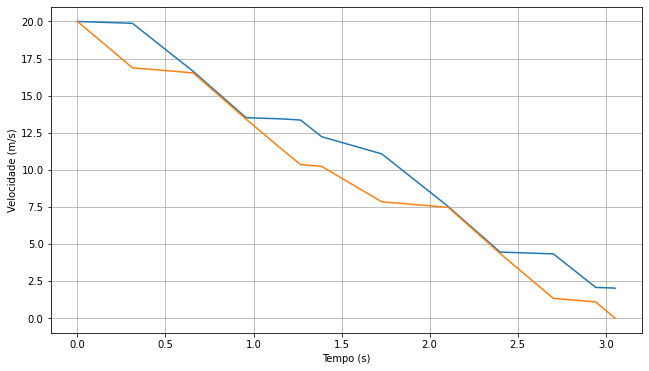

In [ ]:
data = gera_traco(declare, init, trans3, 40, constsT3)
if data:
    plot_speeds(*data)

Estado: 0
t = 0.0
m = Start
vv = 20.0
vr = 20.0
timer = 0.0

Estado: 1
t = 0.0
m = Free
vv = 20.0
vr = 20.0
timer = 0.0

Estado: 2
t = 0.3
m = Free
vv = 19.43
vr = 14.43
timer = 0.3

Estado: 3
t = 0.3
m = Stopping
vv = 19.43
vr = 14.43
timer = 0.0

Estado: 4
t = 0.6246753246753247
m = Stopping
vv = 14.43
vr = 14.43
timer = 0.0

Estado: 5
t = 0.6246753246753247
m = Blocked
vv = 14.43
vr = 14.43
timer = 0.0

Estado: 6
t = 0.9246753246753247
m = Blocked
vv = 11.31
vr = 11.31
timer = 0.3

Estado: 7
t = 0.9246753246753247
m = Free
vv = 11.31
vr = 11.31
timer = 0.0

Estado: 8
t = 1.2246753246753246
m = Free
vv = 11.31
vr = 8.76
timer = 0.3

Estado: 9
t = 1.2246753246753246
m = Stopping
vv = 11.31
vr = 8.76
timer = 0.0

Estado: 10
t = 1.5844155844155845
m = Stopping
vv = 5.77
vr = 5.77
timer = 0.0

Estado: 11
t = 1.5844155844155845
m = Blocked
vv = 5.77
vr = 5.77
timer = 0.0

Estado: 12
t = 1.8844155844155843
m = Blocked
vv = 2.65
vr = 2.625
timer = 0.3

Estado: 13
t = 1.8844155844155843
m = 

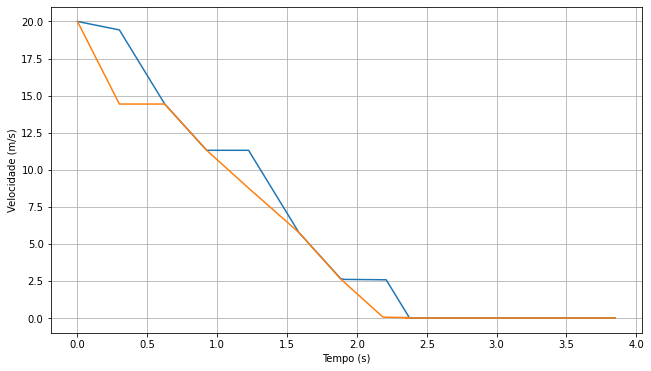

In [ ]:
data = gera_traco(declare, init, trans2, 80, consts)
if data:
    plot_speeds(*data)

###Propriedades/Invariantes Considerados

O veículo imobiliza-se completamente em menos de $t$ segundos, ou seja chegamos a *Stopped* ou tanto a velocidade do veiculo como a velocidade das rodas são $\leq$ 0

$$t \geq t' \rightarrow mode = Stopped \lor (vv \leq 0 \land vr \leq 0)$$

In [ ]:
def prop1(s):
  finalTime = 20
  return Implies(s['t'] >= finalTime, Or(s['m'] == Stopped, And(s['vv'] <= 0, s['vr'] <= 0)))

A velocidade $v$ diminui sempre ao longo do tempo:

$$t < t' \rightarrow vv > vv' $$

In [ ]:
def prop2(s,p):
  return Implies(s['t']<p['t'],s['vv']>p['vv'])

###Verificação das Propriedade
Para garantir a validade das propriedades enunciadas acima vamos servirnos  do Z3, para que em cada uma das K iterações seja simulada uma execução do sistema.Formalizamos assim duas funções de ordem superior a `bmc_eventually`, a `bmc_always` e a `bmc_both`.

Se em alguma das iterações tivermos o resultado insatisfeito, imprimimos os valores das variáveis nessa execução que causaram o desrespeito da regra e terminamos ainda a atividade da função. Concluindo assim que a propriedade não é respeitada e em que momento ocorreu o incumprimento da condição.

Na eventualidade do resultado ser cumprido ao longo das K interações, podemos deduzir que a propriedade ao longo dessas execuções do sistema
foi sempre respeitada. Logo esta **"pode"** ser verdadeiras.

###Teste da Propriedade 1

In [ ]:
def bmc_eventually(declare, init, trans, prop, K, a, b, cF, cS, P, v0):
    for k in range(1, K+1):
        s = Solver()
        traco = [declare(i) for i in range(K)]
        s.add(init(traco[0], v0))

        for i in range(k-1):
            s.add(trans(traco[i], traco[i+1], a, b, cF, cS, P, v0))
        for i in range(k):
            s.add(Not(prop(traco[i])))
        
    if s.check() == sat:
        print("A propriedade falha.")
        m = s.model()
        for i in range(k):
            print("\nEstado", i)
            for v in traco[i]:
                res = m[traco[i][v]]
                if res.sort() != RealSort():
                    print(v, "=", res)
                else:
                    print(v, "=", frac2float(res))

        T  = [frac2float(m[traco[i]["t"]]) for i in range(k)]
        VV = [frac2float(m[traco[i]["vv"]]) for i in range(k)]
        VR = [frac2float(m[traco[i]["vr"]]) for i in range(k)]
        return T, VV, VR
    print("A propriedade é válida em tracos de tamanho até", K)

estados = 10
data = bmc_eventually(declare, init, trans3, prop1, estados, *consts.values())
if data:
    plot_speeds(*data)

A propriedade é válida em tracos de tamanho até 10


###Teste da Propriedade 2

In [ ]:
def bmc_always(declare, init, trans, prop, K, a, b, cF, cS, P, v0):
    for k in range(1, K+1):
        s = Solver()
        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0], v0))
        for i in range(k-1):
          s.add(trans(traco[i], traco[i+1], a, b, cF, cS, P, v0))
          s.add(Not(prop2(traco[i], traco[i+1])))

    if s.check()==sat :
        m = s.model()
        print("A propriedade falha.")
        for i in range(k):
            print("\nEstado: ", i)
            for v in traco[i]:
                res = m[traco[i][v]]
                if res.sort() != RealSort():
                    print(v, "=", res)
                else:
                    print(v, "=", frac2float(res))
    print("A propriedade é válida em traços de tamanho até", K)

estados = 12
bmc_always(declare, init, trans3, prop2, estados, *consts.values())

A propriedade é válida em traços de tamanho até 12
